In [1]:
import os
import pandas as pd
import numpy as np
import json
from itertools import chain
import datetime
from matplotlib import pyplot as plt
import requests
import gmaps
from scipy.stats import linregress
import numpy as np

## Define helper functions to get address details

In [2]:
# load google api key
g_key = None
with open(os.path.expanduser(os.path.join('~', '.api_keys.json')), 'r') as api_fd:
    api_keys = json.load(api_fd)
    g_key = api_keys['google']['key']

def parse_google_response(location_obj):
    results = location_obj['results']
    google_obj = None
    location = {}
    if len(results) > 0:
        google_obj = results[0]
        location = google_obj['geometry']['location']
        address_component_type = [entry['types'][0] for entry in google_obj['address_components']]
        address_component_long_name = [entry['long_name'] for entry in google_obj['address_components']]
        address = dict(zip(address_component_type, address_component_long_name))
        location.update(address)
    return location

# define function to get google place based on address/location
def get_location(address):
    params = {"address": address, "key": g_key}

    # Build URL using the Google Maps API
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    response = requests.get(base_url, params=params)
    location = {}
    if response.status_code == 200:  
        location_obj = response.json()
        location = parse_google_response(location_obj)
    return location

# Configure gmaps with API key
gmaps.configure(api_key=g_key)

## Define helper function to plot total event data over the years

In [3]:
months = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
    'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12,
}

# Tag Category Colors
tags_to_color = {
'Civil Rights': '#FF0000', 'Executive': '#008000','Immigration': '#FF00FF', 'International': '#000080', 'Other': 'black',
 'Environment': '#00FFFF', 'Collective Bargaining': '#D8BFD8', 'Healthcare': '#FFA500', 'Judicial': '#6A5ACD',
 'Legislative': 'yellow', 'Guns': '#BDB76B', 'Education': '#778899' 
}

def fix_month_order(row):
    row['order'] = months[row['month']]
    return row

def plot_total_events_by_year(event_data_ref_df, single_year=None, tag_type='category'):
    # select only events by their main category and drop any rows with no values
    events_by_category = event_data_ref_df.loc[event_data_ref_df['tag_type'] == tag_type, :].dropna(inplace=False)

    #drop any duplicate entries if any
    duplicate_entries = events_by_category.loc[events_by_category.duplicated(['event_id', 'tag']), :].index
    if len(duplicate_entries) > 0:
        events_by_category = events_by_category.drop(index=duplicate)

    total_events_by_year_month_tag = events_by_category.groupby(['year', 'month', 'tag']).count()[['event_id']] \
        .rename(columns={'event_id': 'total events'}) \
        .reset_index()

    if single_year is None:
        plt.figure(figsize=(20,20))

    years = total_events_by_year_month_tag.year.unique()
    unique_tags = total_events_by_year_month_tag.tag.unique()

    for year_i in range(len(years)):
        year = years[year_i]
        current_plot_index = year_i + 1
       
        ax = None
        if (not single_year is None): 
            if  single_year in year:
                print((single_year, year))
                ax = plt.subplot(1, 1, 1)
            else:
                continue
        else:
            ax = plt.subplot(3, 2, current_plot_index)

        for tag in unique_tags:
            subset = total_events_by_year_month_tag.copy().loc[(total_events_by_year_month_tag['year'] == year) & (total_events_by_year_month_tag['tag'] == tag), :]
            
            # some tags are missing data for some months, in this section we fix that by setting total
            # events to 0
            subset['order'] = 0
            subset_months = subset.month.unique()

            for month in months:
                if not month in subset_months:
                    missing_entry = {'year': year, 'month': month, 'tag': tag, 'total events': 0, 'order': 0}
                    subset = subset.append(missing_entry, ignore_index=True)

            # assign order to months
            subset = subset.apply(fix_month_order, axis=1).sort_values(by='order').set_index('order')
            
            ax.bar(subset['month'], subset['total events'], label=f"{tag}", color=tags_to_color[tag])
            ax.set_xticklabels(subset['month'], rotation=90)
            ax.set_title(f"Total events in {year}")
            ax.legend()

# In this analysis we evaluate how the civil unrest in the Los Angeles during 2020 has contributed towards the spread of the Covid-19 Virus

## Load country protest event data

In [4]:
# load protest dataset
parse_event = lambda event: {'id': event['event_id'], 'date': event['event_date'], 'location': event['event_location'], 'attendees': event['event_attendees'], 'primary_url': event['event_primary_url']}
parse_event_tags = lambda event: {'id': event['event_id'], 'tags': event['event_tags'].split('; ')}

event_data = []
event_tags = []
event_tag_types = []
with open(os.path.join('.', 'data', 'count-love-protest-data', 'data.json'), 'r') as protest_data_fd:
    data = json.load(protest_data_fd)
    event_data = list(map(parse_event, data['events']))
    
    event_tags_tmp = list(map(parse_event_tags, data['events']))
    for entry in event_tags_tmp:
        current_event_tags = [{'event_id': entry['id'], 'tag': tag} for tag in entry['tags']]
        event_tags = [*current_event_tags, *event_tags]
    
    for key, data in data['tags'].items():
        event_tag_types_tmp = [{'tag_type': key, 'tag': tag} for tag in data]
        event_tag_types = [*event_tag_types, *event_tag_types_tmp]
        
    print("total events %s" % (len(event_data)) )

event_df = pd.DataFrame(event_data)
event_tags_df = pd.DataFrame(event_tags)
event_tags_type_df = pd.DataFrame(event_tag_types)
tags_complete_df = pd.merge(event_tags_df, event_tags_type_df, how='left', on='tag')
complete_event_data_df = pd.merge(event_df.rename(columns={'id':'event_id'}), tags_complete_df, on='event_id')

# add columns for year and month
complete_event_data_df['month'] = complete_event_data_df['date'].map(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d').strftime('%B'))
complete_event_data_df['year'] = complete_event_data_df['date'].map(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d').strftime('%Y'))

total events 42347


In [5]:
#event_locations_df

* First we open the csv file, load and parse the JSON content
* The data parsed is structured in a big dictionary that contains three index keys: tags, articles and events
* The tags entry is just another dictionary that contains lists of tag types and their corresponding tags
* The events entry is a list of dictionary with information relevant to every event from January 2017 to January 2021
* The articles entry is a list of dictionaries with information about articles and relationships to events

## During the year 2020, the US registered record numbers of Civil Rights related events compared to previous years

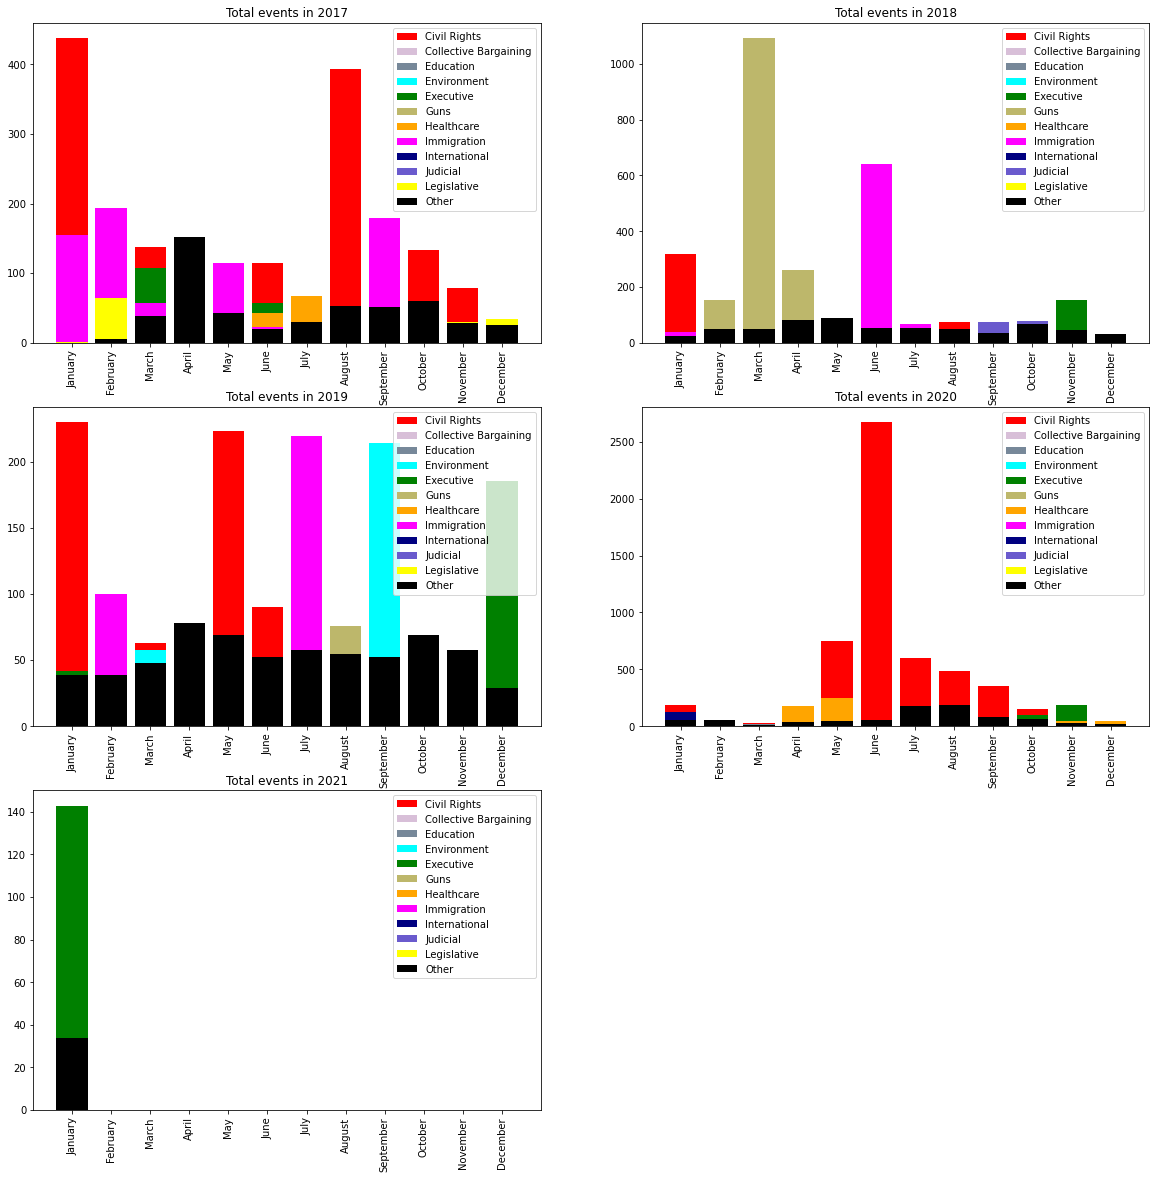

In [6]:
plot_total_events_by_year(complete_event_data_df)
plt.savefig(os.path.join('.', 'data', 'figures', 'usa_protest_data_2017-to-2021.png'))

## The city of los Angeles showed a similar response to the events of 2020
* June being one of the months with more public events

('2020', '2020')


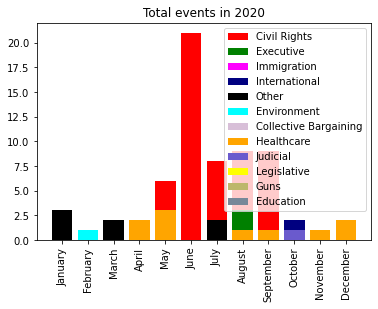

In [7]:
# get los angeles events
la_condition = complete_event_data_df.location.map(lambda entry: 'los angeles' in entry.lower())
los_angeles_event_data_df = complete_event_data_df.loc[la_condition, :]
plot_total_events_by_year(los_angeles_event_data_df, single_year='2020')

plt.savefig('los_angeles_protest_data_2020.png')

### With our dataset, June 2020 registered a total of 160,000 attendees. 

'https://www.latimes.com/california/story/2020-06-08/massive-hollywood-protest-george-floyd-movement'

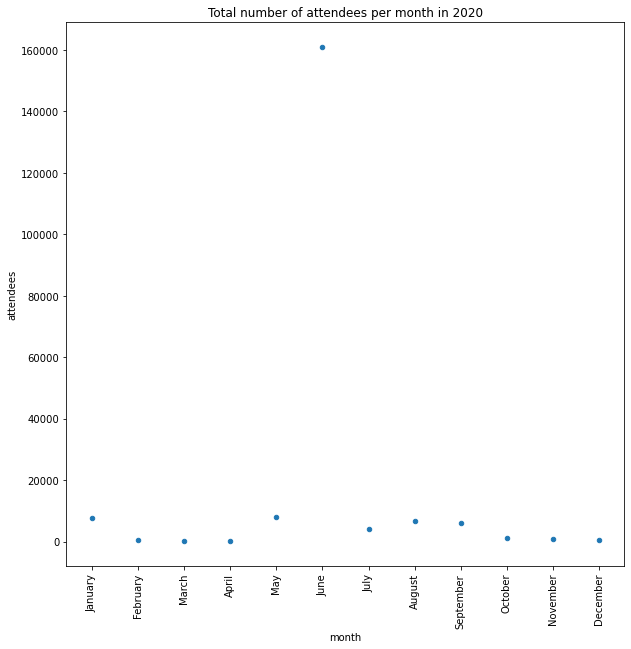

In [8]:
la_2020 = los_angeles_event_data_df.loc[
    (los_angeles_event_data_df['year'] == '2020')
].dropna()
la_total_event_attendees_by_month_2020 = la_2020.groupby('month').sum().reset_index()
la_total_event_attendees_by_month_2020 = la_total_event_attendees_by_month_2020.apply(fix_month_order, axis=1).sort_values(by='order').set_index('order')
ax = la_total_event_attendees_by_month_2020.plot('month', 'attendees', kind='scatter', rot=90, title='Total number of attendees per month in 2020', figsize=(10,10))

ax.figure.savefig(os.path.join('.', 'data', 'figures', 'los_angeles_protest_data_2020.png'))
la_2020.sort_values(by='attendees', ascending=False).iloc[0, :]['primary_url']

## In 2020, Los Angeles population was reported to be a total of 3,983,540 people

In [9]:
event_locations = la_2020.location.unique()
len(event_locations)
event_locations_df_data = []
for loc in event_locations:
    location_obj = get_location(loc)
    location_obj['event_location'] = loc
    event_locations_df_data.append(location_obj)

event_locations_df = pd.DataFrame(event_locations_df_data)
event_locations

array(['Pershing Square, Los Angeles, CA',
       'Los Angeles International Airport, Los Angeles, CA',
       'Arleta, Los Angeles, CA', 'Watts, Los Angeles, CA',
       'Los Angeles, CA', 'City Hall, Los Angeles, CA',
       'Windosr Square, Los Angeles, CA', 'Downtown, Los Angeles, CA',
       'Windsor Square, Los Angeles, CA', 'Fairfax, Los Angeles, CA',
       'Boyle Heights, Los Angeles, CA',
       'LAPD Southeast Station, Los Angeles, CA',
       'Hollywood, Los Angeles, CA', 'West Hollywood, Los Angeles, CA',
       'Civic Center, Van Nuys, Los Angeles, CA',
       'Westwood, Los Angeles, CA', 'Venice, Los Angeles, CA',
       'San Pedro, Los Angeles, CA', 'Venice Beach, Los Angeles, CA',
       ' City Hall, Los Angeles, CA', 'Sherman Oaks, Los Angeles, CA',
       'Grand Park, Los Angeles, CA', 'Tujunga, Los Angeles, CA',
       'Sunland-Tujunga, Los Angeles, CA', 'Van Nuys, Los Angeles, CA',
       'Studio City, Los Angeles, CA', 'Westmont, Los Angeles, CA',
       'Union St

## Average 2020 event attendees in Los Angeles

In [11]:
# get average attendees and merge with respective locations
la_avg_attendees = la_2020.groupby('location').mean()[['attendees']].merge(event_locations_df.set_index('event_location'), left_index=True, right_index=True)
# drop duplicates
la_avg_attendees_clean = la_avg_attendees.drop(index=la_avg_attendees.loc[la_avg_attendees.duplicated(['lat', 'lng']), :].index)
la_avg_attendees_clean.head()

# Store 'Lat' and 'Lng' into  locations 
locations = la_avg_attendees_clean[["lat", "lng"]].astype(float)

# Convert attendees to float and store
# Remember that we handled null values up above.
attendees = la_avg_attendees_clean["attendees"].astype(float)

# Create a poverty Heatmap layer
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=attendees, 
                                 dissipating=False, max_intensity=attendees.max(),
                                 point_radius = 1)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

## Average June 2020 event attendees in Los Angeles

In [12]:
# get average attendees and merge with respective locations
la_june_avg_attendees = la_2020.loc[la_2020['month'] == 'June', :].groupby('location').mean()[['attendees']].merge(event_locations_df.set_index('event_location'), left_index=True, right_index=True)
# drop duplicates
la_june_avg_attendees_clean = la_june_avg_attendees.drop(index=la_june_avg_attendees.loc[la_june_avg_attendees.duplicated(['lat', 'lng']), :].index)
la_june_avg_attendees_clean.head()

# Store 'Lat' and 'Lng' into  locations 
locations = la_june_avg_attendees_clean[["lat", "lng"]].astype(float)

# Convert attendees to float and store
# Remember that we handled null values up above.
attendees = la_june_avg_attendees_clean["attendees"].astype(float)

# Create a poverty Heatmap layer
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=attendees, 
                                 dissipating=False, max_intensity=attendees.max(),
                                 point_radius = 1)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

## Los Angeles Covid19 Data

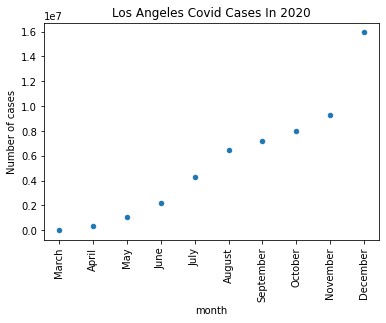

In [13]:
with open(os.path.join('.', 'data', 'anrgusc-lacounty-convid19', 'Covid-19.csv'), 'r', encoding='utf-16') as la_covid_fd:
    la_covid_df = pd.read_csv(la_covid_fd)
la_covid_df['month'] = la_covid_df['Time Stamp'].map(lambda d: datetime.datetime.strptime(d, '%m-%d-%Y').strftime('%B'))
la_covid_df['year'] = la_covid_df['Time Stamp'].map(lambda d: datetime.datetime.strptime(d, '%m-%d-%Y').strftime('%Y'))
la_covid_total_cases_per_year_month = la_covid_df.groupby(['year', 'month']).sum()[['Number of cases']].reset_index()
la_covid_total_cases_per_month_2020 = la_covid_total_cases_per_year_month.loc[la_covid_total_cases_per_year_month['year'] == '2020'].copy().apply(fix_month_order, axis=1).sort_values(by='order').set_index('order')
ax = la_covid_total_cases_per_month_2020.plot('month', 'Number of cases', kind='scatter', rot=90, title='Los Angeles Covid Cases In 2020', )
ax.figure.savefig(os.path.join('.', 'data', 'figures', 'Los_Angeles_Covid_cases_in_2020.png'))

In [ ]:
## 

C:\Users\evera\anaconda3\envs\PythonData\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


R squared undefined


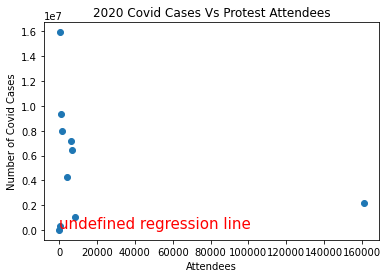

In [14]:
la_attendees_by_month = la_total_event_attendees_by_month_2020.set_index('month')[['attendees']]
la_covid_cases_by_month = la_covid_total_cases_per_month_2020.set_index('month')[['Number of cases']]

la_event_attendees_covid_cases_per_month_2020= pd.merge(la_attendees_by_month, la_covid_cases_by_month, right_index=True, left_index=True, how='outer').reset_index()

la_attendees_covid_cases = la_event_attendees_covid_cases_per_month_2020.apply(fix_month_order, axis=1).sort_values(by='order').set_index('order')

## Convert to floats and store Poverty Rate and Bank Count as x and y values
x_values = la_attendees_covid_cases['attendees'].astype('float')
y_values = la_attendees_covid_cases['Number of cases'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)


if (not np.isnan(slope) ):
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.plot(x_values,regress_values,"r-")
else:
    line_eq = 'undefined regression line'

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line

plt.annotate(line_eq,(20,140000),fontsize=15,color="red")

# Label plot
plt.xlabel('Attendees')
plt.ylabel('Number of Covid Cases')

# Print r square value
if (not np.isnan(rvalue)):
    print(f"R squared: {rvalue**2}")
else:
    print(f"R squared undefined")

plt.title('2020 Covid Cases Vs Protest Attendees')
    
# Show plot


plt.savefig('2020_Covid_Cases_Vs_Protest_Attendees.png')
plt.show()

## New York Times USA Covid19 Data

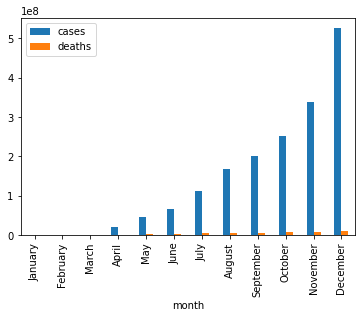

In [15]:
with open(os.path.join('.', 'data', 'nytimes', 'covid-19-data', 'us-states2.csv'), 'r') as us_states_covid_fd:
    us_states_df = pd.read_csv(us_states_covid_fd, sep=',')
    
us_states_df['month'] = us_states_df['date'].map(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d').strftime('%B'))
us_states_df['year'] = us_states_df['date'].map(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d').strftime('%Y'))
#us_states_df.state.unique()
us_states_covid_2020_2021 = us_states_df.groupby(['year', 'month', 'state']).sum()[['cases', 'deaths']].reset_index()
us_covid_2020_2021 = us_states_covid_2020_2021.groupby(['year', 'month']).sum()
us_covid_2020 = us_covid_2020_2021.reset_index().loc[us_covid_2020_2021.reset_index().year == '2020', :]
us_covid_2020 = us_covid_2020.apply(fix_month_order, axis=1).sort_values(by='order').set_index('order')
us_covid_2020.plot('month', ['cases', 'deaths'], kind='bar')